In [2]:
!wget http://download1521.mediafire.com/xp4228fwftsg/qrpbza63ipe095z/database.zip

--2018-08-27 07:52:37--  http://download1521.mediafire.com/xp4228fwftsg/qrpbza63ipe095z/database.zip
Resolving download1521.mediafire.com (download1521.mediafire.com)... 205.196.123.209
Connecting to download1521.mediafire.com (download1521.mediafire.com)|205.196.123.209|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134515649 (128M) [application/zip]
Saving to: ‘database.zip’

database.zip        100%[===================>] 128.28M  2.07MB/s    in 61s     

2018-08-27 07:53:38 (2.10 MB/s) - ‘database.zip’ saved [134515649/134515649]



In [5]:
!unzip database.zip

Archive:  database.zip
  inflating: database.sqlite         


In [6]:
import numpy as np
import pandas as pd
import sqlite3

con = sqlite3.connect('./database.sqlite')

data = pd.read_sql_query("""Select * FROM Reviews WHERE Score != 3""", con)

def partition(x):
  if x > 3:
    return 'Positive'
  else:
    return 'Negative'

actualScore = data['Score']
positiveNegative = actualScore.map(partition)
data['Score'] = positiveNegative

data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Empty DataFrame
Columns: [Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary, Text]
Index: []


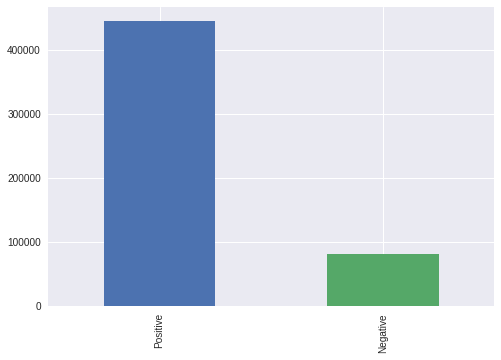

In [7]:
#Checking for Null values

nan = data[data.isnull().any(1)]
print(nan)

data['Score'].value_counts().plot(kind = 'bar')

In [8]:
# Removing duplicate values

sort_data = data.sort_values('ProductId', axis = 0, ascending = True )

data = sort_data.drop_duplicates(subset = {'UserId', 'Text', 'Time', 'ProfileName'}, keep = 'first', inplace = False)

data.shape

(364173, 10)

In [0]:
# Sorting data via Time

data = data.sort_values('Time', axis = 0, ascending = True)

In [10]:
#Text Preprocessing

import re

def cleanhtml(sentence):
  cleantext = re.sub(r'<.*?>', r' ', sentence)
  return cleantext

def cleanpunc(sentence):
  cleaned = re.sub(r'[?|!|\'|"|#]', r' ', sentence)
  cleaned = re.sub(r'[.|,|)|(|\|/]', r' ', cleaned)
  return cleaned


# Cleaning

list_of_sent = []
str1 = ''
final_str = []

for sent in data['Text'].values:
  filtered_sent = []
  sent = cleanhtml(sent)
  for w in sent.split():
    for cleaned_text in cleanpunc(w).split():
      if ((cleaned_text.isalpha()) & (len(cleaned_text) > 2)):
        filtered_sent.append(cleaned_text.lower())
  list_of_sent.append(filtered_sent)

for lst in list_of_sent:
  str1 = ' '.join(lst)
  final_str.append(str1)

data['CleanText'] = final_str

data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,this witty little book makes son laugh loud re...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,Positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,can remember seeing the show when aired televi...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,Positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuice well written movie everything abou...
346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,Positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captured film starring mic...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,Positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuice excellent and funny movie keaton h...


In [11]:
#Applying Bow

from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(ngram_range = (1,2))

bow_data = bow.fit_transform(data['CleanText'])

bow_data.shape

(364173, 3174983)

In [12]:
#Applying Tfidf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfVectorizer(ngram_range = (1,2))
tfidf_data = tfidf.fit_transform(data['CleanText'])

tfidf_data.shape

(364173, 3174983)

In [13]:
!pip install gensim

    100% |████████████████████████████████| 23.5MB 1.5MB/s 
    100% |████████████████████████████████| 1.4MB 12.2MB/s 
    100% |████████████████████████████████| 133kB 22.6MB/s 
    100% |████████████████████████████████| 4.6MB 6.7MB/s 
    100% |████████████████████████████████| 61kB 9.1MB/s 
    100% |████████████████████████████████| 552kB 21.0MB/s 
  Running setup.py bdist_wheel for smart-open ... - \ done
  Stored in directory: /root/.cache/pip/wheels/73/f1/9b/ccf93d4ba073b6f79b1ed9df68ab5ce048d8136d0efcf90b30
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file


In [14]:
#W2v

lst_of_sent = []

for sent in data['Text'].values:
  filtered_sent = []
  sent = cleanhtml(sent)
  for w in sent.split():
    for clean_text in cleanpunc(w).split():
      if((clean_text.isalpha()) & (len(clean_text) > 2)):
         filtered_sent.append(clean_text.lower())
  lst_of_sent.append(filtered_sent)
         
         
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = gensim.models.Word2Vec(lst_of_sent, size = 50, min_count = 5, workers = 4)

print(model.wv.most_similar('tasty'))

[('tastey', 0.9039304256439209), ('yummy', 0.8530311584472656), ('satisfying', 0.8180291652679443), ('delicious', 0.8173473477363586), ('filling', 0.801139771938324), ('flavorful', 0.7571304440498352), ('addicting', 0.7045937776565552), ('tasteful', 0.6999958753585815), ('delish', 0.6998986005783081), ('versatile', 0.688462495803833)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [15]:
#Avg W2V

sent_vectors = []

for sent in lst_of_sent:
  sent_vec = np.zeros(50)
  cnt_words = 0
  for word in sent:
    try:
      vec = model.wv[word]
      sent_vec += vec
      cnt_words += 1
    except:
      pass
  sent_vec /= cnt_words
  sent_vectors.append(sent_vec)
np.shape(sent_vectors)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(364173, 50)

In [0]:
# Confusion, precision and recall matrices

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, y_pred):
  
  C = confusion_matrix(y_test, y_pred)
  
  
  #precision matrix
  
  A = (C/C.sum(axis = 0))
  
  
  #recall matrix
  
  B = ((C.T)/(C.sum(axis = 1))).T
  
  
  labels = ['Negative', 'Positive']
  #Plot confusion matrix
  sns.set_style('whitegrid')
  sns.heatmap(C, annot = True, cmap = 'YlGnBu', fmt = '.3f', xticklabels = labels, yticklabels = labels)
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Class')
  plt.ylabel('Actual Class')
  plt.show()
  
  #Plot precision matrix
  sns.set_style('whitegrid')
  sns.heatmap(A, annot = True, cmap = 'YlGnBu', fmt = '.3f', xticklabels = labels, yticklabels = labels)
  plt.title('Precision Matrix (sum(axis = 0) = 1)')
  plt.xlabel('Predicted Class')
  plt.ylabel('Actual Class')
  plt.show()
  
  #Plot recall matrix
  sns.set_style('whitegrid')
  sns.heatmap(B, annot = True, cmap = 'YlGnBu', fmt = '.3f', xticklabels = labels, yticklabels = labels)
  plt.title('Recall Matrix (sum(axis = 1) = 1)')
  plt.xlabel('Predicted Class')
  plt.ylabel('Actual Class')
  plt.show()


sent_vectors = np.nan_to_num(sent_vectors)

In [18]:
#Dividing BOW, Tfidf and AvgWord2Vec in train, test

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

labels = data['Score']

svd = TruncatedSVD(n_components=2, n_iter=10, random_state=42)
bow_dense = svd.fit_transform(bow_data)
tfidf_dense = svd.fit_transform(tfidf_data)

std_bow = StandardScaler().fit_transform(bow_dense)
std_tfidf = StandardScaler().fit_transform(tfidf_dense)
std_sent_vectors = StandardScaler().fit_transform(sent_vectors)

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split

#bow 
x_b_tr, x_b_test, y_b_tr, y_b_test = cross_validation.train_test_split(std_bow, labels, test_size = 0.2, random_state = 1)

#tfidf
x_t_tr, x_t_test, y_t_tr, y_t_test = cross_validation.train_test_split(std_tfidf, labels, test_size = 0.2, random_state = 1)

#Avgw2v 
x_w2v_tr, x_w2v_test, y_w2v_tr, y_w2v_test = cross_validation.train_test_split(std_sent_vectors, labels, test_size = 0.2, random_state = 1)

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy of KNN on the test data using BOW is 84.16283380243014%


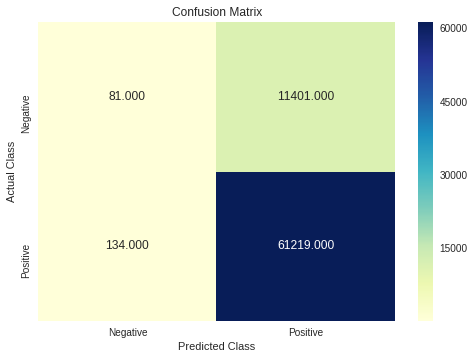

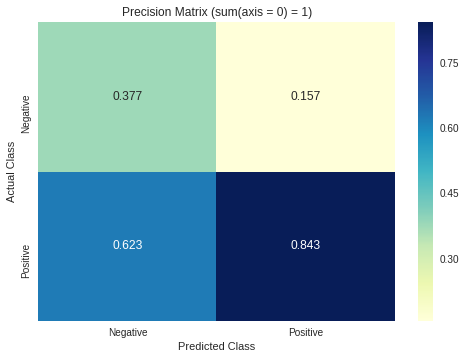

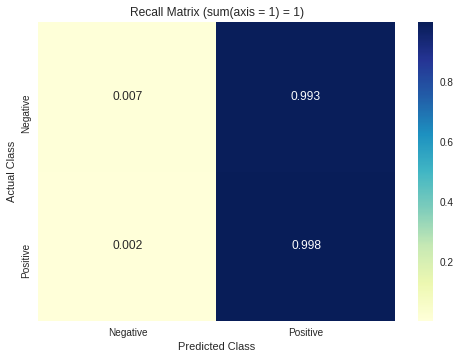

Accuracy of KNN on the test data using BOW is 84.23697398228873%


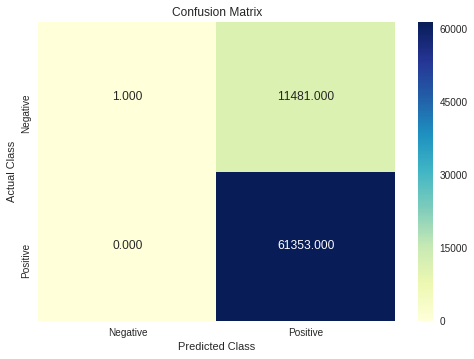

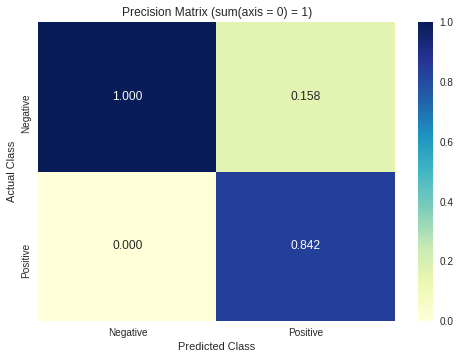

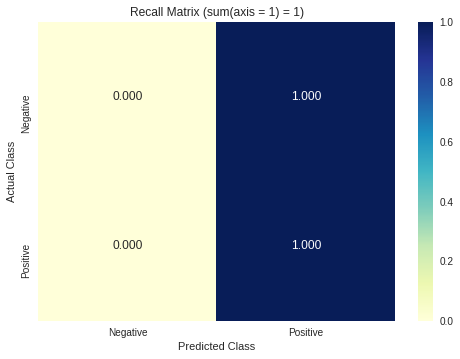

In [19]:
# Applying KNN on BOW, Tfidf

from sklearn.metrics import accuracy_score

from sklearn.cross_validation import cross_val_score

from sklearn.neighbors import KNeighborsClassifier

#bow
neighbors = np.array(np.arange(1,30,2))

cv_scores = []

for k in neighbors:
  knn = KNeighborsClassifier(n_neighbors = k)
  scores = cross_val_score(knn, x_b_tr, y_b_tr, cv = 10, scoring = 'accuracy')
  cv_scores.append(scores.mean())

#Misclassification error
MSE = [1-x for x in cv_scores]

#Optimal K
optimal_k = neighbors[MSE.index(min(MSE))]

#KNN on test

knn = KNeighborsClassifier(n_neighbors = 29)
knn.fit(x_b_tr, y_b_tr)

pred_b = knn.predict(x_b_test)

acc_b = accuracy_score(y_b_test, pred_b, normalize = True) * float(100)
print('Accuracy of KNN on the test data using BOW is {}%'.format(acc_b))

plot_confusion_matrix(y_b_test, pred_b)


#Tfidf
neighbors = np.array(np.arange(1,30,2))

cv_scores = []

for k in neighbors:
  knn = KNeighborsClassifier(n_neighbors = k)
  scores = cross_val_score(knn, x_t_tr, y_t_tr, cv = 10, scoring = 'accuracy')
  cv_scores.append(scores.mean())

#Misclassification error
MSE = [1-x for x in cv_scores]

#Optimal K
optimal_k = neighbors[MSE.index(min(MSE))]

#KNN on test

knn = KNeighborsClassifier(n_neighbors = 29)
knn.fit(x_t_tr, y_t_tr)

pred_t = knn.predict(x_t_test)

acc_t = accuracy_score(y_t_test, pred_t, normalize = True) * float(100)
print('Accuracy of KNN on the test data using BOW is {}%'.format(acc_t))

plot_confusion_matrix(y_t_test, pred_t)

Acuracy of naive bayes on BOW is 84.23560101599506%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


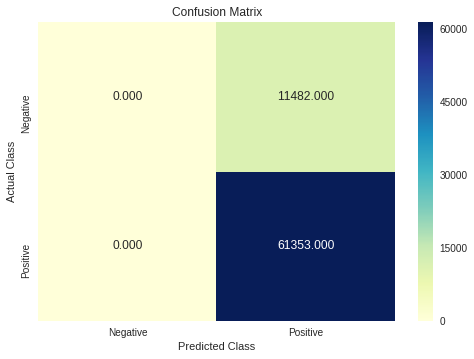

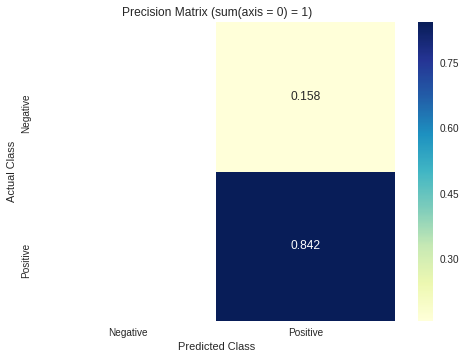

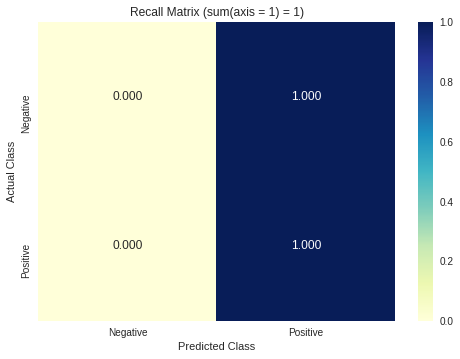

Acuracy of naive bayes on Tfidf is 84.23560101599506%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


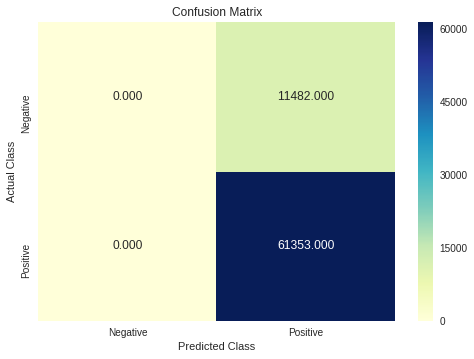

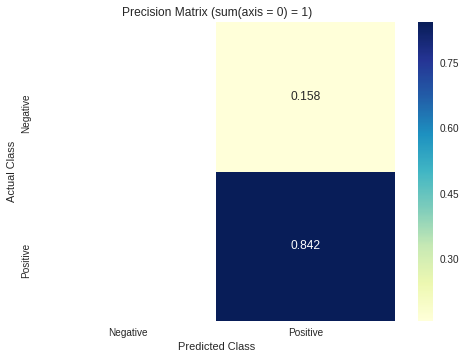

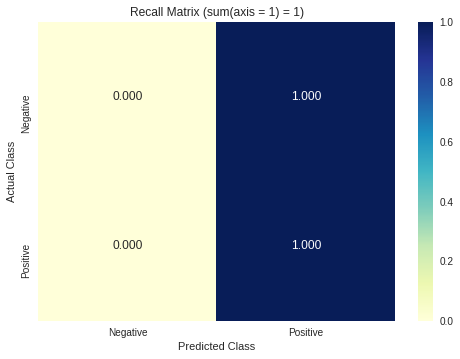

In [20]:
# Naive Bayes on BOW & Tfidf

from sklearn.naive_bayes import BernoulliNB


#for bow

alpha = np.array(np.arange(1,50,2))

cv_scores = []

for a in alpha:
  nb = BernoulliNB(alpha = a)
  scores = cross_val_score(nb, x_b_tr, y_b_tr, cv = 10, scoring = 'accuracy')
  cv_scores.append(scores.mean())

#Misclassification error
MSE = [1-x for x in cv_scores]

optimal_alpha = alpha[MSE.index(min(MSE))]

#on test
nb = BernoulliNB(alpha = optimal_alpha)
nb.fit(x_b_tr, y_b_tr)

pred_b2 = nb.predict(x_b_test)

acc_b2 = accuracy_score(y_b_test, pred_b2, normalize = True) *float(100)
print('Acuracy of naive bayes on BOW is {}%'.format(acc_b2))

plot_confusion_matrix(y_b_test, pred_b2)


#for tfidf

alpha = np.array(np.arange(1,50,2))

cv_scores = []

for a in alpha:
  nb = BernoulliNB(alpha = a)
  scores = cross_val_score(nb, x_t_tr, y_t_tr, cv = 10, scoring = 'accuracy')
  cv_scores.append(scores.mean())

#Misclassification error
MSE = [1-x for x in cv_scores]

optimal_alpha = alpha[MSE.index(min(MSE))]

#on test
nb = BernoulliNB(alpha = optimal_alpha)
nb.fit(x_t_tr, y_t_tr)

pred_t2 = nb.predict(x_t_test)

acc_t2 = accuracy_score(y_t_test, pred_t2, normalize = True) *float(100)
print('Acuracy of naive bayes on Tfidf is {}%'.format(acc_t2))

plot_confusion_matrix(y_t_test, pred_t2)

In [0]:
#KNN on Avg W2V

neighbors = np.array(np.arange(27,45,2))

cv_scores = []

for k in neighbors:
  knn = KNeighborsClassifier(n_neighbors = k)
  scores = cross_val_score(knn, x_w2v_tr, y_w2v_tr, cv = 10, scoring = 'accuracy')
  cv_scores.append(scores.mean())

#Misclassification error
MSE = [1-x for x in cv_scores]
optimal_k = neighbors[MSE.index(min(MSE))]

knn = KNeighborsClassifier(n_neighbors = optimal_k)
knn.fit(x_w2v_tr, y_w2v_tr)

pred_w2v = knn.predict(x_w2v_test)

acc_w2v = accuracy_score(y_w2v_test, pred_w2v, normalize = True) *float(100)
print('Accuracy of KNN on Word2Vec is {}%'.format(acc_w2v))

plot_confusion_matrix(y_w2v_test, pred_w2v)